In [1]:
import cv2
import matplotlib.pyplot as plt
import pytesseract
import numpy as np
from PIL import Image, ImageEnhance, ImageFilter
from pytesseract import Output
from utils import convert_key_value_pairs
pytesseract.pytesseract.tesseract_cmd = r'E:\Downloads\Tesseract OCR\tesseract.exe'

Loading from E:\Nitin\RVCE\Projects\PDF-OCR\code\models
Entities []


In [6]:
def sharpen_image(img):
    # Input:
        # img - image for sharpening
    #kernel for sharpening image
    kernel = np.array([[-1,-1,-1], 
                       [-1, 9,-1],
                       [-1,-1,-1]])

    #Sharpen the image for better text recognition
    sharpened = cv2.filter2D(img, -1, kernel)
    return sharpened

def plot_image(img):
    # @input:
        #img - sharpened image
    #Extract text from image
    text = pytesseract.image_to_string(img)
    plt.imshow(img)
    #Set title of the image as the extracted text
    plt.title(text)
    plt.show()

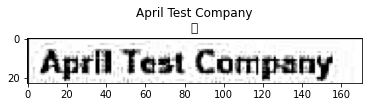

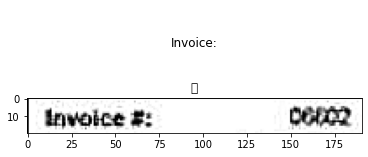

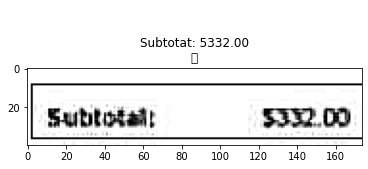

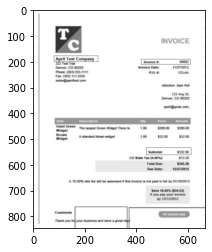

In [8]:

#path = str('E:/Nitin/RVCE/Projects/PDF-OCR/Dataset/receipts/1003-receipt.jpg')

import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt



test_path = './Sample images/test_1.JPG'

img = cv.imread(test_path,0)

# coordinates for rectangle - 
    # (x1,y1) - top left corner
    # (x2,y2) - bottom right corner

cv.rectangle(img, (81,177), (252,200), (0,0,255), 1) #company
cv.rectangle(img, (419,190), (610,210), (0,0,255), 1) #invoice number
cv.rectangle(img, (439,533), (613,561), (0,0,255), 1) #subtotal

# bottom right corner of the table
table_end = (606,505)
#vertical distance of subtotal field from end of table - should write code to get this
subtotal_diff_y = 32
#height of the subtotal field - should write code to get this
subtotal_h = 30

#convert to RGB scale
img = cv.cvtColor(img,cv.COLOR_BGR2RGB)

#company name
company = img[177:200,81:252]
#sharpen image
sharpened = sharpen_image(company)
plot_image(sharpened)


#invoice number
invoice_number = img[190:210,419:610]
#Sharpen the image for better text recognition
sharpened = sharpen_image(invoice_number)
plot_image(sharpened)

#subtotal
subtotal = img[table_end[1]+subtotal_diff_y-10:table_end[1]+subtotal_diff_y+subtotal_h,439:613]
sharpened = sharpen_image(subtotal)
kernel = np.zeros((3,3),np.uint8)
sharpened = cv2.erode(sharpened,kernel,iterations=2)
plot_image(sharpened)

plt.imshow(img)